# Logistic Regression with L2-regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 
# Fire up graphLab create
 
Make sure you have the latest version of GraphLab Create (1.8.3 or later). If you don't find the decision tree module, then you would need to upgrade graphlab-create using

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [1]:
from __future__ import division
import graphlab

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in the previous assignment from last module. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews. (**Add link to the subset data**).

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476110900.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476110900.log


This non-commercial license of GraphLab Create for academic use is assigned to tmandzak@gmail.com and will expire on May 12, 2017.


Just like we did previously, we will work with only a subset of **important** words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the important_words)

Refer to notes in the second assignment from the previous module for more details.

In [3]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [4]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=1` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of selected model should always be on test data.

In [5]:
train_data, validation_data = products.random_split(.8, seed=1)

print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

Training set   : 42474 data points
Validation set : 10598 data points


## Convert SFrame to NumPy array

Just like in the second assignment of the previous module, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [6]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [7]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [8]:
feature_matrix_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [9]:
sentiment_train

array([ 1,  1,  1, ..., -1, -1, -1])

## Building on logistic regression with no L2 penalty assignment

Let us now build on the second assignment of the previous module. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [11]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    scores = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1 / (1+np.exp(-scores))
    
    # return predictions
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with an L2 penalty. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log-likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelikelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [12]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(feature, errors)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2 * l2_penalty * coefficient
        
    return derivative

** Quiz question:** In the code above, was the intercept term regualrized?

To verify the correctness of the gradient descent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [13]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

** Quiz question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [14]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j]:
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for an L2 solver with logistic regression, let's explore the benefits of using **L2 regularization** while analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [15]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29256.53509469
iteration   1: log likelihood of observed labels = -29080.15933459
iteration   2: log likelihood of observed labels = -28910.70310738
iteration   3: log likelihood of observed labels = -28747.51727534
iteration   4: log likelihood of observed labels = -28590.11088099
iteration   5: log likelihood of observed labels = -28438.09355101
iteration   6: log likelihood of observed labels = -28291.14073932
iteration   7: log likelihood of observed labels = -28148.97259118
iteration   8: log likelihood of observed labels = -28011.34094170
iteration   9: log likelihood of observed labels = -27878.02119960
iteration  10: log likelihood of observed labels = -27748.80718346
iteration  11: log likelihood of observed labels = -27623.50775262
iteration  12: log likelihood of observed labels = -27501.94453552
iteration  13: log likelihood of observed labels = -27383.95033346
iteration  14: log likelihood of observed labels = -27269.3679

In [16]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29256.54440918
iteration   1: log likelihood of observed labels = -29080.21358862
iteration   2: log likelihood of observed labels = -28910.83503659
iteration   3: log likelihood of observed labels = -28747.75716882
iteration   4: log likelihood of observed labels = -28590.48687541
iteration   5: log likelihood of observed labels = -28438.63184287
iteration   6: log likelihood of observed labels = -28291.86575113
iteration   7: log likelihood of observed labels = -28149.90711030
iteration   8: log likelihood of observed labels = -28012.50624217
iteration   9: log likelihood of observed labels = -27879.43715190
iteration  10: log likelihood of observed labels = -27750.49235500
iteration  11: log likelihood of observed labels = -27625.47950047
iteration  12: log likelihood of observed labels = -27504.21909206
iteration  13: log likelihood of observed labels = -27386.54288558
iteration  14: log likelihood of observed labels = -27272.2927

In [17]:
# run with L2 = 25
coefficients_25_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=25, max_iter=501)

iteration   0: log likelihood of observed labels = -29256.55838091
iteration   1: log likelihood of observed labels = -29080.29495592
iteration   2: log likelihood of observed labels = -28911.03286391
iteration   3: log likelihood of observed labels = -28748.11682836
iteration   4: log likelihood of observed labels = -28591.05049080
iteration   5: log likelihood of observed labels = -28439.43860961
iteration   6: log likelihood of observed labels = -28292.95218757
iteration   7: log likelihood of observed labels = -28151.30726772
iteration   8: log likelihood of observed labels = -28014.25188887
iteration   9: log likelihood of observed labels = -27881.55793921
iteration  10: log likelihood of observed labels = -27753.01596927
iteration  11: log likelihood of observed labels = -27628.43180316
iteration  12: log likelihood of observed labels = -27507.62424921
iteration  13: log likelihood of observed labels = -27390.42348751
iteration  14: log likelihood of observed labels = -27276.6698

In [18]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29256.62823956
iteration   1: log likelihood of observed labels = -29080.70154526
iteration   2: log likelihood of observed labels = -28912.02080432
iteration   3: log likelihood of observed labels = -28749.91187801
iteration   4: log likelihood of observed labels = -28593.86180762
iteration   5: log likelihood of observed labels = -28443.46039146
iteration   6: log likelihood of observed labels = -28298.36496072
iteration   7: log likelihood of observed labels = -28158.27896711
iteration   8: log likelihood of observed labels = -28022.93880567
iteration   9: log likelihood of observed labels = -27892.10557528
iteration  10: log likelihood of observed labels = -27765.55981884
iteration  11: log likelihood of observed labels = -27643.09807298
iteration  12: log likelihood of observed labels = -27524.53052351
iteration  13: log likelihood of observed labels = -27409.67934231
iteration  14: log likelihood of observed labels = -27298.3774

In [19]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29257.46654341
iteration   1: log likelihood of observed labels = -29085.54856449
iteration   2: log likelihood of observed labels = -28923.72175265
iteration   3: log likelihood of observed labels = -28771.03546664
iteration   4: log likelihood of observed labels = -28626.73397364
iteration   5: log likelihood of observed labels = -28490.18963521
iteration   6: log likelihood of observed labels = -28360.86278202
iteration   7: log likelihood of observed labels = -28238.27724819
iteration   8: log likelihood of observed labels = -28122.00512090
iteration   9: log likelihood of observed labels = -28011.65695208
iteration  10: log likelihood of observed labels = -27906.87523962
iteration  11: log likelihood of observed labels = -27807.32988968
iteration  12: log likelihood of observed labels = -27712.71489976
iteration  13: log likelihood of observed labels = -27622.74581080
iteration  14: log likelihood of observed labels = -27537.1576

In [20]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29349.67996719
iteration   1: log likelihood of observed labels = -29349.56226752
iteration   2: log likelihood of observed labels = -29349.55642623
iteration   3: log likelihood of observed labels = -29349.55401770
iteration   4: log likelihood of observed labels = -29349.55195595
iteration   5: log likelihood of observed labels = -29349.55009433
iteration   6: log likelihood of observed labels = -29349.54840914
iteration   7: log likelihood of observed labels = -29349.54688349
iteration   8: log likelihood of observed labels = -29349.54550226
iteration   9: log likelihood of observed labels = -29349.54425177
iteration  10: log likelihood of observed labels = -29349.54311966
iteration  11: log likelihood of observed labels = -29349.54209472
iteration  12: log likelihood of observed labels = -29349.54116680
iteration  13: log likelihood of observed labels = -29349.54032672
iteration  14: log likelihood of observed labels = -29349.5395

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [21]:
table = graphlab.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [22]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_25_penalty, 'coefficients [L2=25]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=10],coefficients [L2=25],coefficients [L2=1e2]
(intercept),-0.0745874045386,-0.0730565738301,-0.0708333228327,-0.0609039624246
baby,0.0914044653289,0.0909240723926,0.0902332807203,0.0872120460521
one,0.022029160162,0.0213184487289,0.0203003714841,0.0159507965338
great,0.80062465855,0.788856874407,0.771995780055,0.699758211124
love,1.03975150459,1.02121922381,0.994719015489,0.88209210377
use,0.012980586266,0.0134691827886,0.0141658171897,0.0170725614152
would,-0.290384002777,-0.287850795321,-0.284225153494,-0.268704669272
like,-0.00915773854399,-0.00923734577053,-0.00935293774877,-0.00985497846215
easy,0.974789783574,0.957918557952,0.933790447327,0.831173338471
little,0.527735163007,0.520240965265,0.509509821615,0.463614351574


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [29]:
positive_words = table.topk('coefficients [L2=0]', 5)['word']
positive_words

dtype: str
Rows: 5
['loves', 'love', 'easy', 'perfect', 'great']

In [30]:
negative_words = table.topk('coefficients [L2=0]', 5, reverse = True)['word']
negative_words

dtype: str
Rows: 5
['disappointed', 'money', 'return', 'waste', 'returned']

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

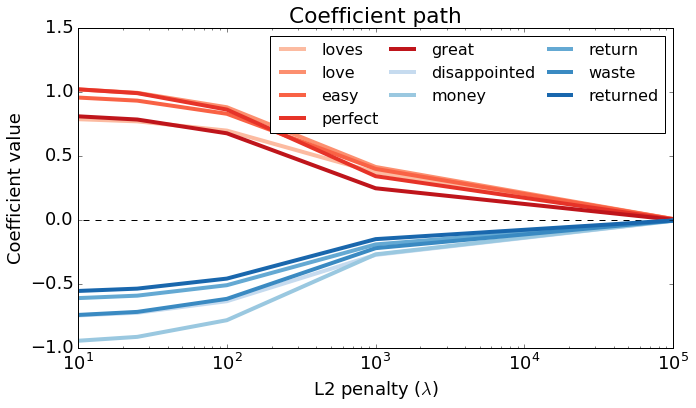

In [32]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 10, 25, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as L2 penalty is increased.

**Quiz Question**: (True/False) Relative order of coefficients is preserved as L2 penalty is increased. (If word 'cat' was more positive than word 'dog', then it remains to be so as L2 penalty is increased.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with L2 penalty. The only thing that changes is that the estimated coefficients used in this prediction are different with L2 penalty.

Based on the above, we will use the same code that was used in the previous logistic regression assignment.

In [33]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate these accuracies and then build a simple report summarizing the performance for the various models.

In [34]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[25]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_25_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[25]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_25_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [35]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 = 0
train accuracy = 0.785586476433, validation_accuracy = 0.785525570862
--------------------------------------------------------------------------------
L2 = 10
train accuracy = 0.785398125912, validation_accuracy = 0.785619928288
--------------------------------------------------------------------------------
L2 = 25
train accuracy = 0.785139143947, validation_accuracy = 0.785242498585
--------------------------------------------------------------------------------
L2 = 100
train accuracy = 0.783914865565, validation_accuracy = 0.784204566899
--------------------------------------------------------------------------------
L2 = 1000
train accuracy = 0.773673306023, validation_accuracy = 0.771277599547
--------------------------------------------------------------------------------
L2 = 100000
train accuracy = 0.744267081038, validation_accuracy = 0.740800150972
--------------------------------------------------------------------------------


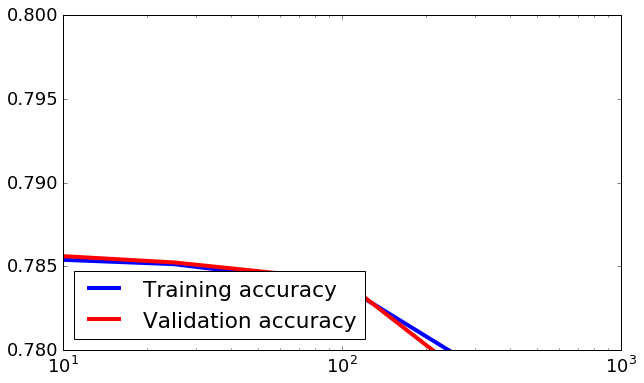

In [36]:
sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'b-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'r-', linewidth=4, label='Validation accuracy')
plt.xscale('log')
plt.axis([1e1, 1e3, 0.78, 0.80])
plt.legend(loc='lower left')

* **Quiz question**: Which model (L2 = 0, 10, 25, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz question**: Which model (L2 = 0, 10, 25, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?